In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("studydata.csv")

# Create 'totalscore' column
df['totalscore'] = df['math_score'] + df['reading_score'] + df['writing_score']

# Calculate percentiles
percentiles = df['totalscore'].quantile([0.25, 0.4, 0.7])

# Function to assign division based on percentile
def assign_division(score):
    if score > percentiles[0.7]:
        return 'First Division'
    elif score > percentiles[0.4]:
        return 'Second Division'
    elif score > percentiles[0.25]:
        return 'Third Division'
    else:
        return 'Fail'

# Create 'division' column
df['division'] = df['totalscore'].apply(assign_division)

# Display the updated DataFrame
df.head()


,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,totalscore,division
0,female,group B,bachelor's degree,standard,none,72,72,74,218,Second Division
1,female,group C,some college,standard,completed,69,90,88,247,First Division
2,female,group B,master's degree,standard,none,90,95,93,278,First Division
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,Fail
4,male,group C,some college,standard,none,76,78,75,229,First Division


In [2]:
# Perform one-hot encoding on categorical variables
df_encoded = pd.get_dummies(df, columns=['gender', 'test_preparation_course', 'lunch'])

# Display the updated DataFrame
df_encoded.head()


,race_ethnicity,parental_level_of_education,math_score,reading_score,writing_score,totalscore,division,gender_female,gender_male,test_preparation_course_completed,test_preparation_course_none,lunch_free/reduced,lunch_standard
0,group B,bachelor's degree,72,72,74,218,Second Division,1,0,0,1,0,1
1,group C,some college,69,90,88,247,First Division,1,0,1,0,0,1
2,group B,master's degree,90,95,93,278,First Division,1,0,0,1,0,1
3,group A,associate's degree,47,57,44,148,Fail,0,1,0,1,1,0
4,group C,some college,76,78,75,229,First Division,0,1,0,1,0,1


In [3]:
# Define predictor variables and target variable
predictors = df_encoded[['gender_female', 'gender_male', 
                         'test_preparation_course_completed', 'test_preparation_course_none', 
                         'lunch_free/reduced', 'lunch_standard']]
target = df_encoded['division']

# Display the predictor variables and target variable
print("Predictor Variables:")
print(predictors.head())
print("\nTarget Variable:")
print(target.head())


Predictor Variables:
   gender_female  gender_male  test_preparation_course_completed  \
0              1            0                                  0   
1              1            0                                  1   
2              1            0                                  0   
3              0            1                                  0   
4              0            1                                  0   

   test_preparation_course_none  lunch_free/reduced  lunch_standard  
0                             1                   0               1  
1                             0                   0               1  
2                             1                   0               1  
3                             1                   1               0  
4                             1                   0               1  

Target Variable:
0    Second Division
1     First Division
2     First Division
3               Fail
4     First Division
Name: division, dtype: obje

In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable ('division') into integer labels
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors, target_encoded, test_size=0.25, random_state=42)

# Train the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Decode integer labels back to original categories for evaluation
y_train_pred_decoded = label_encoder.inverse_transform(y_train_pred)
y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)

# Evaluate the model
print("Accuracy on Train Dataset:", accuracy_score(y_train, y_train_pred))
print("Accuracy on Test Dataset:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report on Test Dataset:")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix on Test Dataset:")
print(confusion_matrix(y_test, y_test_pred))


Accuracy on Train Dataset: 0.3973333333333333
Accuracy on Test Dataset: 0.364

Classification Report on Test Dataset:
              precision    recall  f1-score   support

           0       0.48      0.40      0.44        72
           1       0.39      0.56      0.46        71
           2       0.25      0.33      0.29        67
           3       0.00      0.00      0.00        40

    accuracy                           0.36       250
   macro avg       0.28      0.32      0.30       250
weighted avg       0.32      0.36      0.33       250


Confusion Matrix on Test Dataset:
[[29 13 30  0]
 [12 40 19  0]
 [ 7 38 22  0]
 [12 12 16  0]]


C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


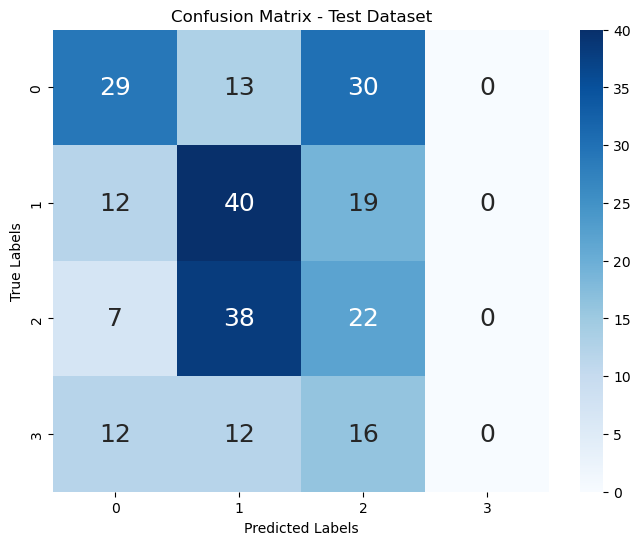

Accuracy on Train Dataset: 0.3973333333333333
Accuracy on Test Dataset: 0.364


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix heatmap for test dataset
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt=".0f", annot_kws={"size": 18}, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Dataset')
plt.show()

# Display accuracy results
print("Accuracy on Train Dataset:", accuracy_score(y_train, y_train_pred))
print("Accuracy on Test Dataset:", accuracy_score(y_test, y_test_pred))

<Figure size 1000x600 with 0 Axes>

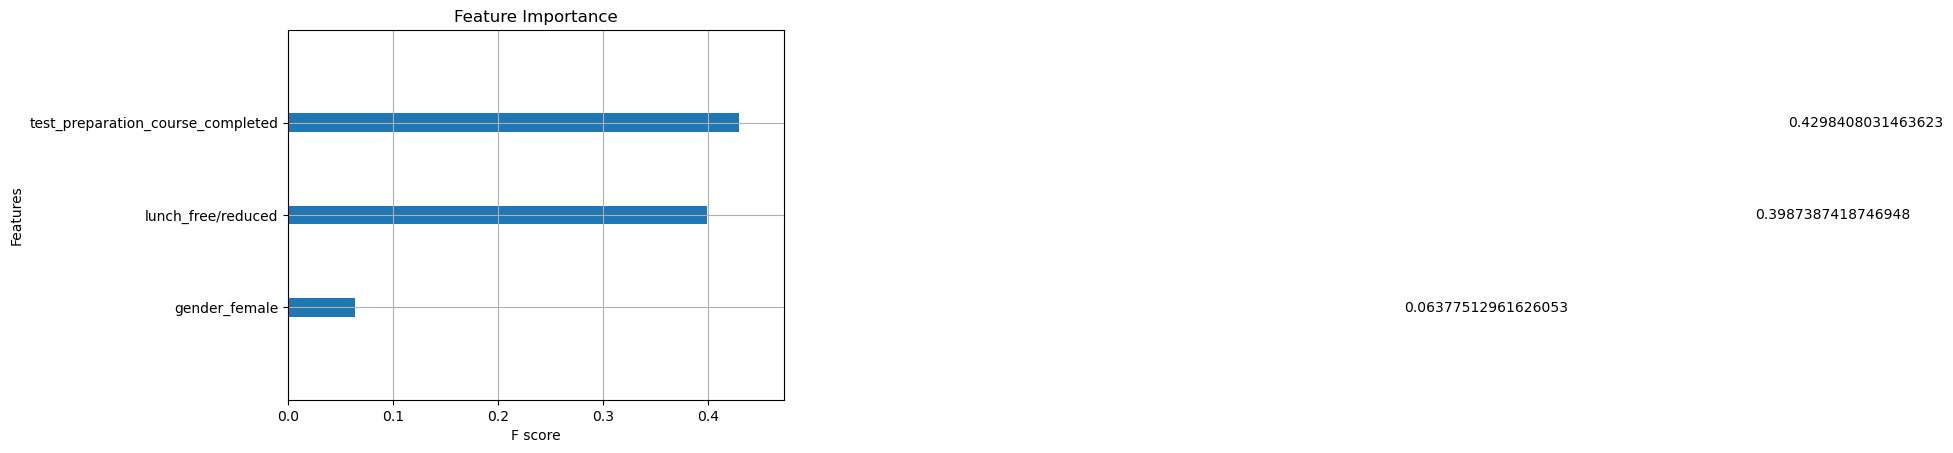

In [11]:
# Plot feature importance
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='gain', max_num_features=10, title='Feature Importance')
plt.show()

In [12]:
# Perform one-hot encoding on categorical variables
df_encoded = pd.get_dummies(df, columns=['race_ethnicity', 'parental_level_of_education'])

# Display the updated DataFrame
df_encoded.head()


,gender,lunch,test_preparation_course,math_score,reading_score,writing_score,totalscore,division,race_ethnicity_group A,race_ethnicity_group B,race_ethnicity_group C,race_ethnicity_group D,race_ethnicity_group E,parental_level_of_education_associate's degree,parental_level_of_education_bachelor's degree,parental_level_of_education_high school,parental_level_of_education_master's degree,parental_level_of_education_some college,parental_level_of_education_some high school
0,female,standard,none,72,72,74,218,Second Division,0,1,0,0,0,0,1,0,0,0,0
1,female,standard,completed,69,90,88,247,First Division,0,0,1,0,0,0,0,0,0,1,0
2,female,standard,none,90,95,93,278,First Division,0,1,0,0,0,0,0,0,1,0,0
3,male,free/reduced,none,47,57,44,148,Fail,1,0,0,0,0,1,0,0,0,0,0
4,male,standard,none,76,78,75,229,First Division,0,0,1,0,0,0,0,0,0,1,0


In [13]:
# Define predictor variables and target variable
predictors = df_encoded.drop(['gender', 'lunch', 'test_preparation_course', 'math_score', 'reading_score', 'writing_score', 'totalscore', 'division'], axis=1)
target = df_encoded['division']

# Display the predictor variables and target variable
print("Predictor Variables:")
print(predictors.head())
print("\nTarget Variable:")
print(target.head())


Predictor Variables:
   race_ethnicity_group A  race_ethnicity_group B  race_ethnicity_group C  \
0                       0                       1                       0   
1                       0                       0                       1   
2                       0                       1                       0   
3                       1                       0                       0   
4                       0                       0                       1   

   race_ethnicity_group D  race_ethnicity_group E  \
0                       0                       0   
1                       0                       0   
2                       0                       0   
3                       0                       0   
4                       0                       0   

   parental_level_of_education_associate's degree  \
0                                               0   
1                                               0   
2                                     

In [15]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable into numerical format
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)

# Display the unique encoded class labels
print("Encoded Class Labels:", label_encoder.classes_)


Encoded Class Labels: ['Fail' 'First Division' 'Second Division' 'Third Division']


In [16]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(predictors, target_encoded, test_size=0.2, random_state=42)

# Train the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4)
xgb_model.fit(X_train, y_train)

# Predictions
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Evaluate the model
print("Accuracy on Train Dataset:", accuracy_score(y_train, y_train_pred))
print("Accuracy on Test Dataset:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report on Test Dataset:")
print(classification_report(y_test, y_test_pred))
print("\nConfusion Matrix on Test Dataset:")
print(confusion_matrix(y_test, y_test_pred))


Accuracy on Train Dataset: 0.3825
Accuracy on Test Dataset: 0.31

Classification Report on Test Dataset:
              precision    recall  f1-score   support

           0       0.31      0.24      0.27        58
           1       0.37      0.34      0.36        58
           2       0.29      0.51      0.37        55
           3       0.00      0.00      0.00        29

    accuracy                           0.31       200
   macro avg       0.24      0.27      0.25       200
weighted avg       0.28      0.31      0.28       200


Confusion Matrix on Test Dataset:
[[14 15 27  2]
 [10 20 28  0]
 [11 15 28  1]
 [10  4 15  0]]


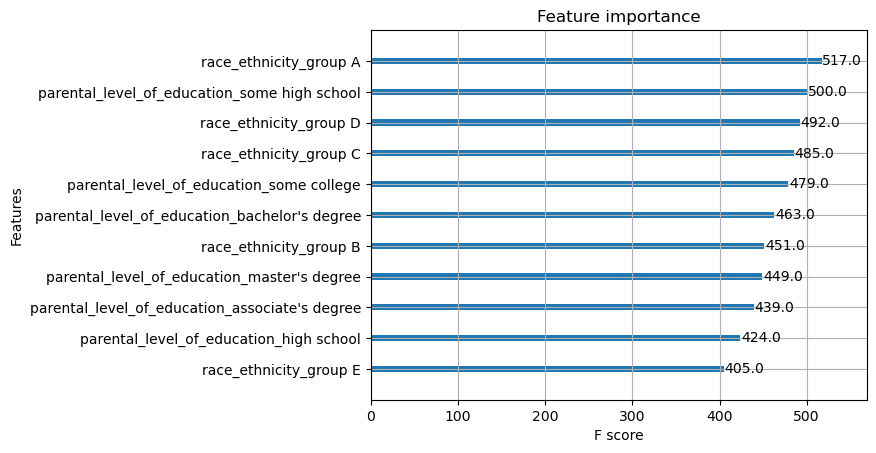

In [17]:
# Plot feature importance
xgb.plot_importance(xgb_model)
plt.show()
